# Understand the Basics
- Essential of GIS and Climate data concepts
    - Data types
          - Vector data -
          - Raster -
          - Tabular
    - common climatic Variables for Nepal
      - Temperature
      - Precipitation
      - Snow cover
      - Glacial Data
      - Extreme weather events
      - Land Use/Land cover change
- Data Sources
  - National Sources - DHM, Survey Department in Nepal, Ministry of Forest and environment
  - International data - WorldClim, NASA Earth Data, USGS Earth Explorer,

In [7]:
# Install the packages
! pip install geopandas matplotlib numpy pandas seaborn rasterio folium

In [8]:
# Import the libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import folium


# Basic EDA: Importing data and examining the data

In [9]:
nepal = gpd.read_file('https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_NPL_0.json')
# Check the basic information
print(nepal.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GID_0     1 non-null      object  
 1   COUNTRY   1 non-null      object  
 2   geometry  1 non-null      geometry
dtypes: geometry(1), object(2)
memory usage: 156.0+ bytes
None


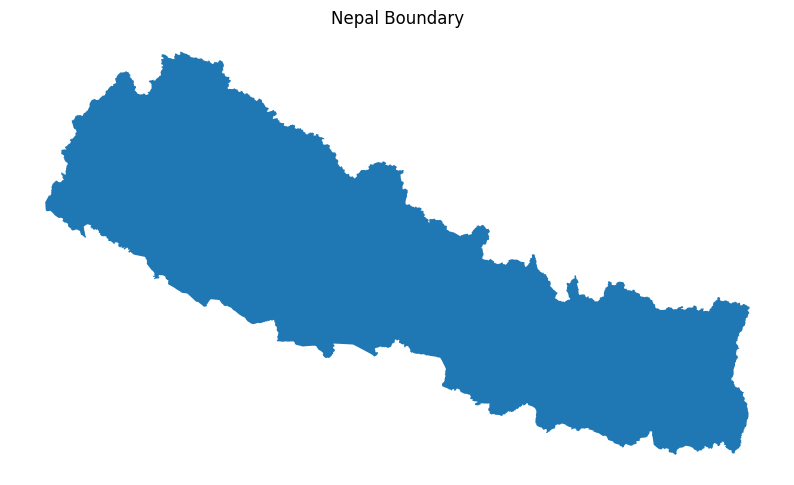

In [10]:
# Plot the boundary of the data
fig, ax = plt.subplots(figsize = (10,8))
nepal.plot(ax = ax)
ax.set_title("Nepal Boundary")
plt.axis('off')
plt.show()

In [11]:
# Check for the coordinate reference system
print(nepal.crs)

EPSG:4326


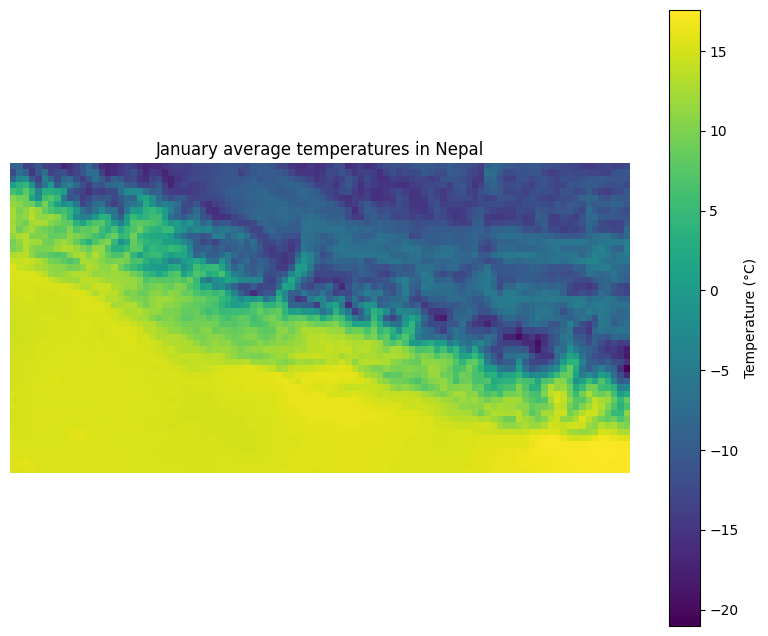

Min temperature: -21.025999069213867
Max temperature: 17.57200050354004
Mean temperature: 3.0172345638275146
Standard Deviation: 11.77917194366455


In [12]:
# Load the sample data
temp_file = r"C:\Users\Learner\Desktop\-111daysofCFCchallenge\wc2.1_5m_tavg\wc2.1_5m_tavg_01.tif"

# open the raster file
with rasterio.open(temp_file) as src:
    # Read the data for nepals bounding box
    nepal_bounds = nepal.total_bounds
    window = rasterio.windows.from_bounds(*nepal_bounds, src.transform)
    nepal_temp = src.read(1, window = window)
    # get the transofrm for the window
    nepal_transform = rasterio.windows.transform(window, src.transform)


    # Plot the data
    fig, ax = plt.subplots(figsize = (10, 8))
    im = ax.imshow(nepal_temp, cmap = 'viridis')
    plt.colorbar(im, label = "Temperature (°C)")
    ax.set_title("January average temperatures in Nepal")
    plt.axis('off')
    plt.show()


    # Basic statisctics
    print(f"Min temperature: {np.nanmin(nepal_temp)}")
    print(f"Max temperature: {np.nanmax(nepal_temp)}")
    print(f"Mean temperature: {np.nanmean(nepal_temp)}")
    print(f"Standard Deviation: {np.nanstd(nepal_temp)}")

# Creating and interactive visualization with Folium

In [13]:
nepal_districts = gpd.read_file('https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_NPL_0.json')

# Create an interactive map of Nepal
m = folium.Map(location= [28.3949, 84.124], zoom_start = 7)

# add boundaries for Nepal
folium.GeoJson(
    nepal.__geo_interface__,
    name = "Nepal"
).add_to(m)

# Add the district Boundaries
district_style = lambda x: {'fillcolor': '#ffff00', 'color' : '#000000', 'weight' : 1, 'fillOpacity' : 0.1}
folium.GeoJson(
    nepal_districts.__geo_interface__,
    name = 'Districts',
    style_function = district_style,
    tooltip = folium.GeoJsonTooltip(fields= ['GID_0'], aliases = ['District:'])
).add_to(m)

# Add stations
stations = pd.DataFrame({
    'name': ['Kathmandu', 'Pokhara', 'Jumla', 'Dhankuta', 'Nepalgunj', 'Dhangandhi', 'Jomsom'],
    'lat': [27.7172, 28.2096, 29.2747, 26.9833, 28.0500, 28.7000, 28.7800],
    'lon': [85.3240, 83.9856, 82.1838, 87.3333, 81.6167, 80.5800, 83.7200],
    'elevation': [1400, 872, 2300, 1200, 190, 109, 2800],
    'temp_trend': [0.03, 0.02, 0.04, 0.025, 0.03, 0.035, 0.05]
})

for idx, row in stations.iterrows():
    folium.CircleMarker(
        location = [row['lat'], row['lon']],
        radius = row['temp_trend'] * 100, # size based on warming trend
        popup = f"Station: {row['name']}<br> Elevation: {row['elevation']}m<br>Trend: {row['temp_trend']} °C/yr",
        color = 'red',
        fill = True,
        fill_color = 'red',
    ).add_to(m)

# Add a legend
from branca.element import Template, MacroElement
template= """
{% macro html(this, kwargs) %}
<div style="position: fixed;
    bottom: 50px; right: 50px; width: 150px; height: 90px;
    border: 2px solid grey; z-index:9999; font-size:14px;
    background-color:white;
    padding: 10px;
    ">
    <b>Temperature Trend</b><br>
    Color Size indicates<br>
    warming rate (°C/year)
</div>
{% endmacro %}
"""
macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

# Display this map
m